# Setting path

In [2]:
base_path = "1_reshape"

In [1]:
import numpy as np
import tensorflow as tf

class HI_Generator(tf.keras.utils.Sequence):
    def __init__(self, data_path_list, batch_size):
        self.data_path_list = data_path_list # your data
        self.batch_size = batch_size # your batch size

    def __len__(self):
        return len(self.data_path_list) // self.batch_size # number of batches per epoch

    def __getitem__(self, index):
    
        # generate one batch of data
        start = index * self.batch_size
        end = (index + 1) * self.batch_size
        batch_data_path_list = self.data_path_list[start:end] # get a slice of data

        # do some preprocessing or augmentation here if needed
        imgs = list()
        for data_path in batch_data_path_list:
            img = np.load(data_path)
            img = img / 200 # normalize    上面的"了解最大值" => 當作feature scaling的標準
            img[np.isnan(img)] = 0
            imgs.append(img)

        return (np.array(imgs), np.array(imgs)) # return a batch of data

In [3]:
from glob import glob
TRN_HI_Generator = HI_Generator(data_path_list=glob("dataset/TRN_IMGS_for_AE/*.npy"), batch_size=256)
TST_HI_Generator = HI_Generator(data_path_list=glob("dataset/TST_IMGS_for_AE/*.npy"), batch_size=256)

In [4]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import layers, losses
# Define the encoder model
input_img = tf.keras.Input(shape=(33,25)) # input image shape
three_d_image = tf.expand_dims(input_img, axis=-1)
resized_image = tf.image.resize(three_d_image, size=(28, 28))
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(resized_image) # convolutional layer
x = layers.MaxPooling2D((2, 2), padding='same')(x) # pooling layer
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x) # another convolutional layer
x = layers.MaxPooling2D((2, 2), padding='same')(x) # another pooling layer
x = layers.Conv2D(4, (3, 3), activation='relu', padding='same')(x) # another convolutional layer
x = layers.MaxPooling2D((2, 2), padding='same')(x)
encoded = layers.Flatten()(x) # output of encoder

encoder = tf.keras.Model(input_img, encoded, name="encoder") # create encoder model
# encoder.summary()


# Define the decoder model
encoded_input = tf.keras.Input(shape=(64)) # input of decoder (same as output of encoder)
x = layers.Reshape((4,4,4))(encoded_input)
x = layers.Conv2D(4, (3, 3), activation='relu', padding='same')(x) # convolutional layer
x = layers.Conv2DTranspose(8, (2, 2), strides=2)(x) # upsampling layer
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x) # another convolutional layer
x = layers.Conv2DTranspose(8, (2, 2), strides=2)(x) # another upsampling layer
x = layers.Conv2D(16,(3 ,3), activation ='relu' )( x )# another convolutional layer 
x = layers.Conv2DTranspose(16, (2, 2), strides=2)( x )# another upsampling layer 
decoded=layers.Conv2D(1, (3, 3) ,activation ='relu', padding="same" )( x )# output of decoder 
resized_decoded = tf.image.resize(decoded, size=(33,25))

decoder=tf.keras.Model(encoded_input ,resized_decoded, name="decoder")# create decoder model 
# decoder.summary()

In [5]:
# Define the autoencoder model by combining encoder and decoder models 
autoencoder=tf.keras.Model(input_img ,decoder(encoder(input_img )))# create autoencoder model 
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 33, 25)]          0         
                                                                 
 encoder (Functional)        (None, 64)                1612      
                                                                 
 decoder (Functional)        (None, 33, 25, 1)         3485      
                                                                 
Total params: 5,097
Trainable params: 5,097
Non-trainable params: 0
_________________________________________________________________


In [6]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [7]:
history = autoencoder.fit(
    TRN_HI_Generator,
    epochs=50,
    shuffle=True,
    validation_data=TST_HI_Generator
)

Epoch 1/50
3171/3171 [==============================] - 6062s 2s/step - loss: 7.8653e-04 - val_loss: 7.7065e-05
Epoch 2/50
3171/3171 [==============================] - 5576s 2s/step - loss: 2.7798e-04 - val_loss: 3.7758e-05
Epoch 3/50
3171/3171 [==============================] - 5505s 2s/step - loss: 2.9335e-04 - val_loss: 3.8140e-05
Epoch 4/50
3171/3171 [==============================] - 5728s 2s/step - loss: 2.4872e-04 - val_loss: 2.9109e-05
Epoch 5/50
3171/3171 [==============================] - 5574s 2s/step - loss: 2.2678e-04 - val_loss: 7.3186e-05
Epoch 6/50
3171/3171 [==============================] - 5760s 2s/step - loss: 2.3853e-04 - val_loss: 2.7918e-05
Epoch 7/50
3171/3171 [==============================] - 7407s 2s/step - loss: 2.0298e-04 - val_loss: 3.1615e-04
Epoch 8/50
3171/3171 [==============================] - 6195s 2s/step - loss: 2.1556e-04 - val_loss: 2.5983e-05
Epoch 9/50
3171/3171 [==============================] - 5387s 2s/step - loss: 1.7923e-04 - val_loss: 1.8

In [8]:
# Upsample2D
autoencoder.evaluate(TRN_HI_Generator)

3171/3171 [==============================] - 3492s 1s/step - loss: 8.8021e-05


8.802094089332968e-05

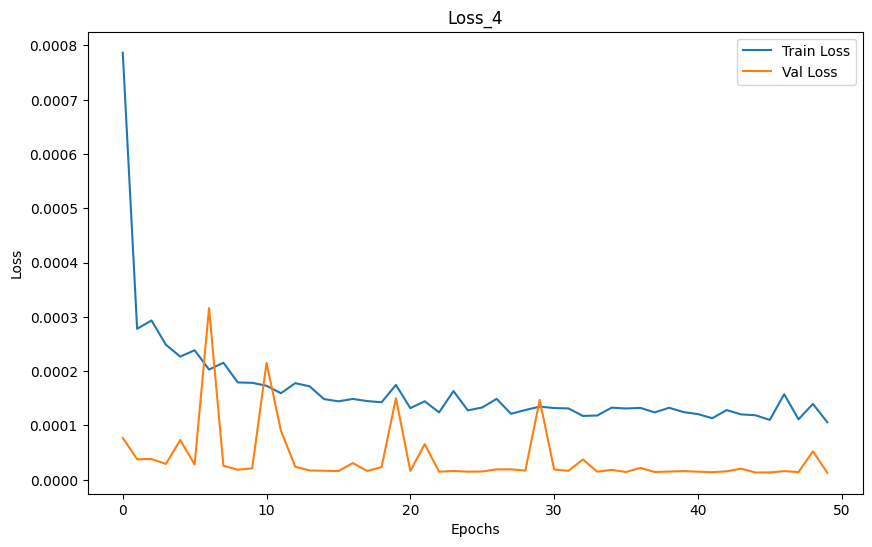

<Figure size 640x480 with 0 Axes>

In [9]:
import matplotlib.pyplot as plt

trn_loss = history.history["loss"]
val_loss = history.history["val_loss"]

plt.figure(figsize=(10,6))
plt.plot(trn_loss, label="Train Loss")
plt.plot(val_loss, label="Val Loss")
plt.title("Loss_4")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()
plt.savefig(f"{base_path}/result/Train_loss_4")

In [10]:
autoencoder.layers

In [11]:
encoder_model = tf.keras.Sequential(autoencoder.layers[:2])
decoder_model = tf.keras.Sequential(autoencoder.layers[2:])

In [12]:
encoder_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Functional)        (None, 64)                1612      
                                                                 
Total params: 1,612
Trainable params: 1,612
Non-trainable params: 0
_________________________________________________________________


In [13]:
decoder_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder (Functional)        (None, 33, 25, 1)         3485      
                                                                 
Total params: 3,485
Trainable params: 3,485
Non-trainable params: 0
_________________________________________________________________


In [14]:
autoencoder.save(f"{base_path}/model/autoencoder_4.h5")
encoder_model.save(f"{base_path}/model/encoder_4.h5")
decoder_model.save(f"{base_path}/model/decoder_4.h5")

In [15]:
# 取出影像

from glob import glob
import numpy as np
import random

tst_imgs = glob(f"dataset/TST_IMGS_for_AE/*.npy")
n = random.randint(0,len(tst_imgs))
tst_img = np.load(tst_imgs[n])

In [16]:
encoder_input = tst_img.reshape(1,33,25)/200
encoder_output = encoder(encoder_input)
decoder_output = decoder(encoder_output)

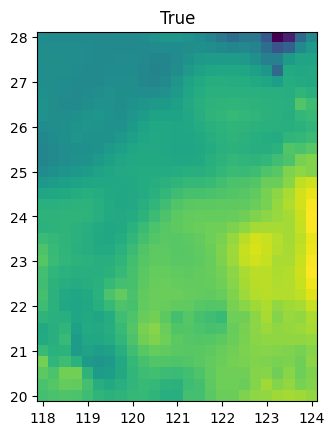

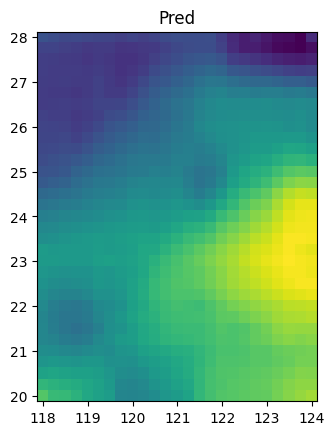

In [17]:
import matplotlib.pyplot as plt
plt.figure(1)
plt.title("True")
y = range(0,32+1,4)
x = range(0,25+1,4)
plt.yticks(y,np.arange(20,28+1,1))
plt.xticks(x,np.arange(118,124+1,1))
plt.imshow(tst_img,origin = "lower")
plt.figure(2)
plt.title("Pred")
y = range(0,32+1,4)
x = range(0,25+1,4)
plt.yticks(y,np.arange(20,28+1,1))
plt.xticks(x,np.arange(118,124+1,1))
plt.imshow(decoder_output.numpy().reshape(33,25),origin = "lower")

In [6]:
encoder_output_folder = f"{base_path}/npy/encoder_4"

In [7]:
from glob import glob
import numpy as np
en_imgs = sorted(glob(f"dataset/TST_IMGS_for_AE/*.npy"))

for idx, HI in enumerate(en_imgs):
    target_name = en_imgs[idx].split("/")[1].split("\\")[1].split(".")[0]
    en_trn_img = np.load(en_imgs[idx])
    encoder_input = en_trn_img.reshape(1,33,25)
    encoder_output = encoder(encoder_input).numpy()

    np.save(f"{encoder_output_folder}/{target_name}", encoder_output)

## load

In [3]:
import tensorflow as tf
autoencoder = tf.keras.models.load_model(f"{base_path}/model/autoencoder_4.h5")
encoder = tf.keras.models.load_model(f"{base_path}/model/encoder_4.h5")
decoder = tf.keras.models.load_model(f"{base_path}/model/decoder_4.h5")

In [4]:
from scipy.io import loadmat as lm
from tqdm import tqdm
import numpy as np
from glob import glob

HI_mat_path = sorted(glob(f"{base_path}/npy/encoder_4/*.npy"))  #讀資料夾路徑

HI_mat = list()
HI_mat_test = list()
name_train = list()
name_test = list()

for i,  filename in tqdm(enumerate(HI_mat_path)): #讀檔名 tqdm:呈現for loop進度
    if i >= len(HI_mat_path)-96:
        data = np.load(f"{filename}")
        HI_mat_test.append(data)
        day = HI_mat_path[i].split("\\")[1].split(".")[0].split("_")[1]
        time = '{:02}{:02}'.format(int(HI_mat_path[i].split("\\")[1].split(".")[0].split("_")[2])//4, int(HI_mat_path[i].split("\\")[1].split(".")[0].split("_")[2])%4*15)
        name_test.append(f"{day}_{time}")
    
    else:
        data = np.load(f"{filename}")
        HI_mat.append(data)
        day = HI_mat_path[i].split("\\")[1].split(".")[0].split("_")[1]
        time = '{:02}{:02}'.format(int(HI_mat_path[i].split("\\")[1].split(".")[0].split("_")[2])//4, int(HI_mat_path[i].split("\\")[1].split(".")[0].split("_")[2])%4*15)
        name_train.append(f"{day}_{time}")

HI_mat = np.array(HI_mat)
HI_mat_test = np.array(HI_mat_test)

203808it [25:30, 133.17it/s]


# Plot True/ Autoencoder

MovieWriter ffmpeg unavailable; using Pillow instead.


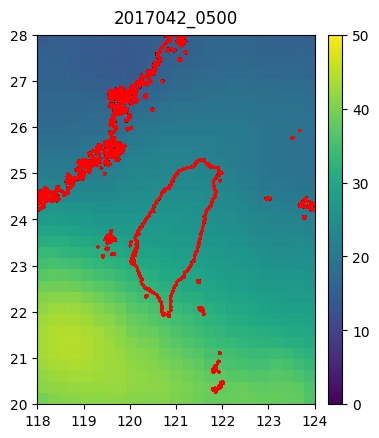

In [6]:
from glob import glob
import numpy as np
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.axes_grid1 import make_axes_locatable

asian_map = np.load("asian_map.npy")
tst_imgs = sorted(glob(f"dataset/TST_IMGS_for_AE/*.npy"))[20:20+96]
true_imgs = list()
name = list()

#image load & name add
for i in range(len(tst_imgs)):
    img = np.load(tst_imgs[i])
    true_imgs.append(img)
    day = tst_imgs[i].split("\\")[1].split(".")[0].split("_")[1]
    time = '{:02}{:02}'.format(int(tst_imgs[i].split("\\")[1].split(".")[0].split("_")[2])//4, int(tst_imgs[i].split("\\")[1].split(".")[0].split("_")[2])%4*15)
    name.append(f"{day}_{time}")
    
true_imgs = np.array(true_imgs)
autoencoder_imgs = autoencoder(true_imgs).numpy().reshape(len(true_imgs),33,25)

fig = plt.figure() # 創建圖形物件
ims = []

ax = fig.add_subplot(111)
div = make_axes_locatable(ax)
cax = div.append_axes('right', '5%', '5%')
cmap = "jet"

def animate(i):
    cax.cla()
    tx, ty = [118,20]
    ax.set_xlim(118,124)
    ax.set_ylim(20,28)
    data = autoencoder_imgs
    
    title_name = name[i]
    title = plt.text(-11,51,f"{title_name}", ha="center",va="bottom", fontsize="large")
    im = ax.imshow(data[i], origin = "lower", zorder = 1, extent = (tx,tx+6,ty,ty+8), clim = [0,50])#, cmap = cmap)  #-------------------Here to change the colorbar range
    ax.plot(asian_map[:,0], asian_map[:,1], c = "r", zorder = 2)
    fig.colorbar(im, cax=cax)

video_name_STLSQ = f"{base_path}/result/Pred_autoencoder_4.gif"
ani = animation.FuncAnimation(fig, animate, interval=500, frames = len(true_imgs))
ani.save(f"{video_name_STLSQ}")

# MSE

In [ ]:
loss = list()
for i in range(len(true_imgs)):
    encoder_input = true_imgs[i].reshape(1,33,25)/200
    encoder_output = encoder(encoder_input)
    decoder_output = decoder(encoder_output).numpy().reshape(1,33,25)
    loss.append(np.sum((decoder_output - encoder_input) ** 2))
np.save(f"{base_path}/npy/loss_4",loss)

In [6]:
loss = np.load(f"{base_path}/npy/loss_4.npy")

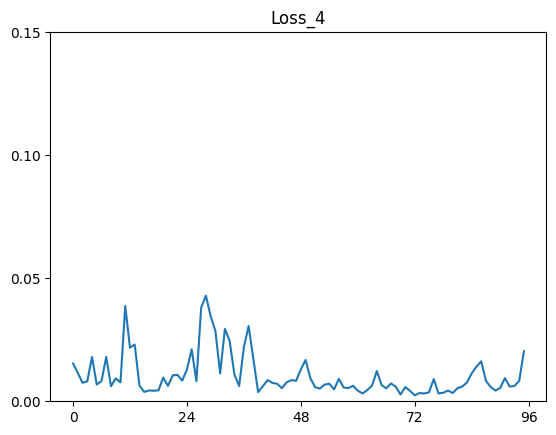

In [7]:
import matplotlib.pyplot as plt

plt.plot(loss)
plt.xticks(np.arange(0,96+1,24))
plt.yticks(np.arange(0,0.2,0.05))
plt.title("Loss_4")
plt.savefig(f"{base_path}/result/loss_4")